In [1]:
from src import SQL_Executor, SQL_Queries
import pandas as pd

executor = SQL_Executor()
query = SQL_Queries().DPD()

installments_df = executor.execute_query(query.installments())
transactions_with_age_income_df = executor.execute_query(
    query.transactions_with_age_income()
)

ModuleNotFoundError: No module named 'src'

In [2]:
def _create_labels(bins_inc: list[int]) -> tuple[list[str], list[str]]:
    labels = []
    bins = bins_inc + [float("inf")]
    for i in range(len(bins) - 1):
        if bins[i + 1] == float("inf"):
            label = f"{bins[i]}+"
        else:
            label = f"{bins[i]}-{bins[i + 1] - 1}"
        labels.append(label)
    return bins, labels


def group_by_column(
    df: pd.DataFrame,
    bins_inc: list[str],
    target_column: str,
    column: str,
    drop_column: str = None,
):
    bins, labels = _create_labels(bins_inc)

    if drop_column:
        df = df.drop(columns=drop_column)

    group_column = f"group_{column}"
    df[group_column] = pd.cut(df[column], bins=bins, labels=labels)

    output_column = f"{target_column}_rate"
    df = df.groupby(group_column, observed=True).agg(
        **{output_column: (target_column, lambda x: (x.mean() * 100).round(2))}
    )

    return df

In [3]:
dpd_df = installments_df.copy()
scheduled_date = pd.to_datetime(dpd_df["scheduled_date"])
payment_date = pd.to_datetime(dpd_df["payment_date"])
today = pd.Timestamp.today()

dpd_df["dpd"] = 0

dpd_df.loc[payment_date > scheduled_date, "dpd"] = (
    payment_date - scheduled_date
).dt.days

dpd_df.loc[payment_date.isna(), "dpd"] = (today - scheduled_date).dt.days.clip(lower=0)

dpd_df = dpd_df.drop(columns=["payment_date", "scheduled_date"])

In [4]:
dpd_df["dpd90"] = (dpd_df["dpd"] >= 90).astype(int)
dpd_df = dpd_df.groupby("transaction_id").agg({"dpd90": "max"})
dpd_df = transactions_with_age_income_df.merge(dpd_df, on="transaction_id", how="left")

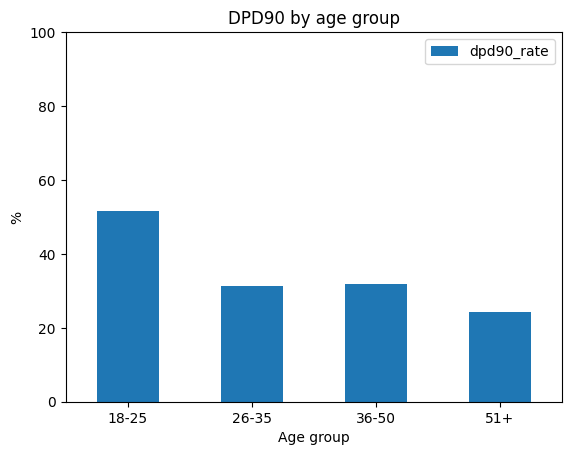

In [5]:
bins = [18, 26, 36, 51]
dpd_rates_age = group_by_column(dpd_df, bins, "dpd90", "age", "income")
dpd_rates_age.plot(
    kind="bar",
    title="DPD90 by age group",
    rot=0,
    ylim=(0, 100),
    xlabel="Age group",
    ylabel="%",
);

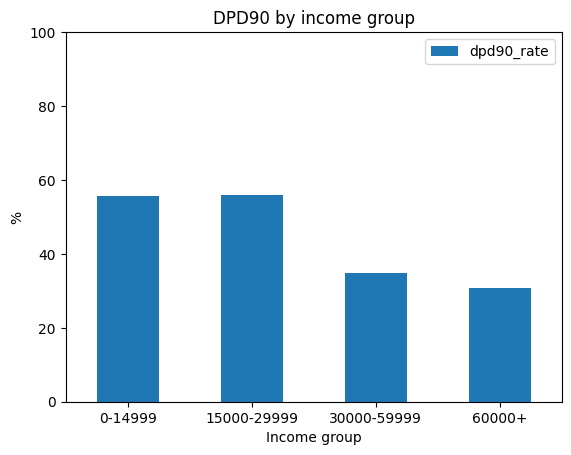

In [6]:
bins = [0, 15000, 30000, 60000]
dpd_rates_income = group_by_column(dpd_df, bins, "dpd90", "income", "age")
dpd_rates_income.plot(
    kind="bar",
    title="DPD90 by income group",
    rot=0,
    ylim=(0, 100),
    xlabel="Income group",
    ylabel="%",
);